In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import dblquad
from scipy.special import gamma
import utils

In [3]:
figsize = (12, 6)

In [4]:
def _const_curve(t):
    return np.full(len(t), .234**2) if isinstance(t, np.ndarray) else .234**2

In [5]:
xi_1 = utils.VarianceCurve(_const_curve)
xi_2 = utils.VarianceCurve(lambda t: .234**2 * (1. + t)**2)
xi_3 = utils.VarianceCurve(lambda t: .234**2 * np.sqrt(1. + t))

$$
\xi_t(u) = \mathbb{E}[V_u|\mathcal{F}_t], \qquad u > t
$$

# Domands for Jimssss

1. Wtf is the time unit?
2. Why is $C_H$ buggy?

In [6]:
print(f"xi_1 = {xi_1(utils.DELTA):.6f}")
print(f"xi_2 = {xi_2(utils.DELTA):.6f}")
print(f"xi_3 = {xi_3(utils.DELTA):.6f}")

xi_1 = 0.054756
xi_2 = 0.064262
xi_3 = 0.056992


In [7]:
print(f"xi_1 = {xi_1(0):.6f}")
print(f"xi_2 = {xi_2(0):.6f}")
print(f"xi_3 = {xi_3(0):.6f}")

xi_1 = 0.054756
xi_2 = 0.054756
xi_3 = 0.054756


In [8]:
labels = [
    r"Scenario 1: $\xi_0(t) \, = \, 0.234^2$",
    r"Scenario 2: $\xi_0(t) \, = \, 0.234^2(1+t)^2$",
    r"Scenario 3: $\xi_0(t) \, = \, 0.234^2\sqrt{1+t}$"
]

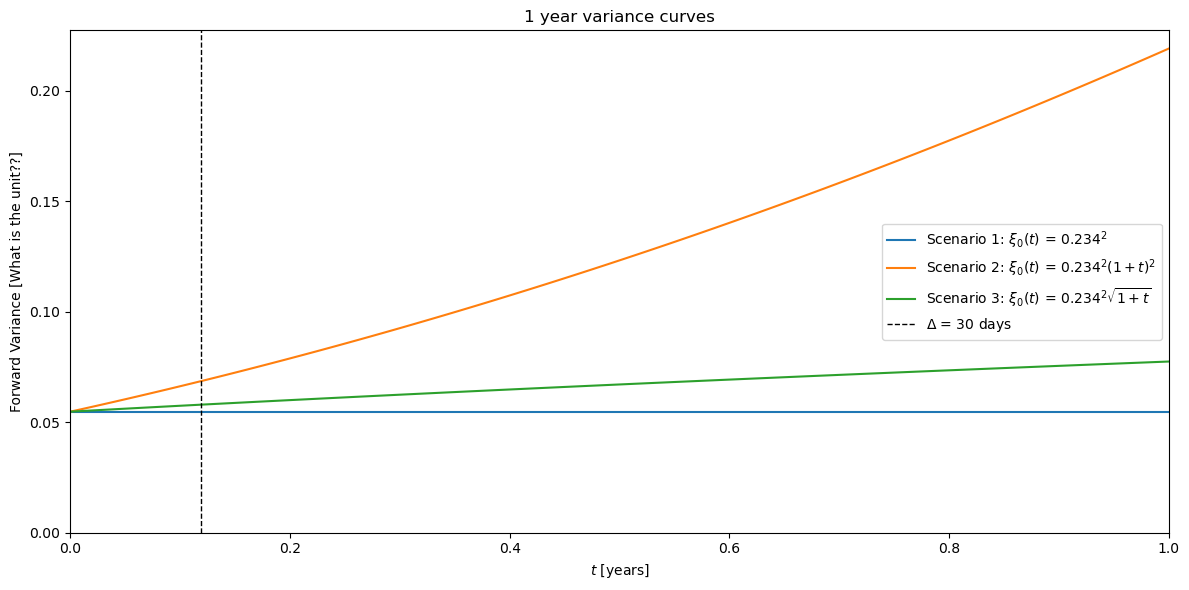

In [9]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
xaxis = np.linspace(0, 1., 100)

ax.plot(xaxis, xi_1(xaxis), label=labels[0])
ax.plot(xaxis, xi_2(xaxis), label=labels[1])
ax.plot(xaxis, xi_3(xaxis), label=labels[2])

ax.axvline(utils.DELTA, ls='--', lw=1, color='black', label=r'$\Delta$ = 30 days')

ax.set_title("1 year variance curves")
ax.set_xlabel(r"$t$ [years]"); ax.set_ylabel("Forward Variance [What is the unit??]")
ax.set_ylim(bottom=0); ax.set_xlim(0, 1)
ax.legend()

fig.tight_layout()
plt.savefig('./Plots/fwd_var_curves.png')
plt.show()

# Pricing

In [9]:
import warnings
warnings.filterwarnings('ignore')

Possible fixes:
* $\nu = 1.9\frac{C_H\sqrt{2H}}{2} \rightarrow$ NOPE
* $\nu \approx 1.2287$
* $\xi_0 = 0.235^2$
* $\xi_0 = 0.234^2$

In [10]:
H = utils.Hurst(0.07)
eta = 1.9
volvol = 1.2287  # 1.9 * utils.c_h(H) * np.sqrt(H.h2) / 2
print(volvol)
print(1.9 * utils.c_h(H) * np.sqrt(H.h2) / 2 / np.sqrt(H.h2))

1.2287
0.27483677700206116


In [26]:
def price(curve, volvol, T):
    exp_vix = utils.expected_vix_sq(curve, T=T)
    exp_vix_sq = utils.moment2_vix_sq(curve, utils.DELTA, volvol, H, T=T)
    # return np.sqrt(np.exp(utils.mu_lognormal(exp_vix, exp_vix_sq)) / utils.DELTA)
    return utils.VIX_price(curve, exp_vix, exp_vix_sq, utils.DELTA, T=T)

In [11]:
def price_jim(curve, volvol, T):
    return utils.VIX_price_jim_2(curve, eta, H, utils.DELTA, T=T)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


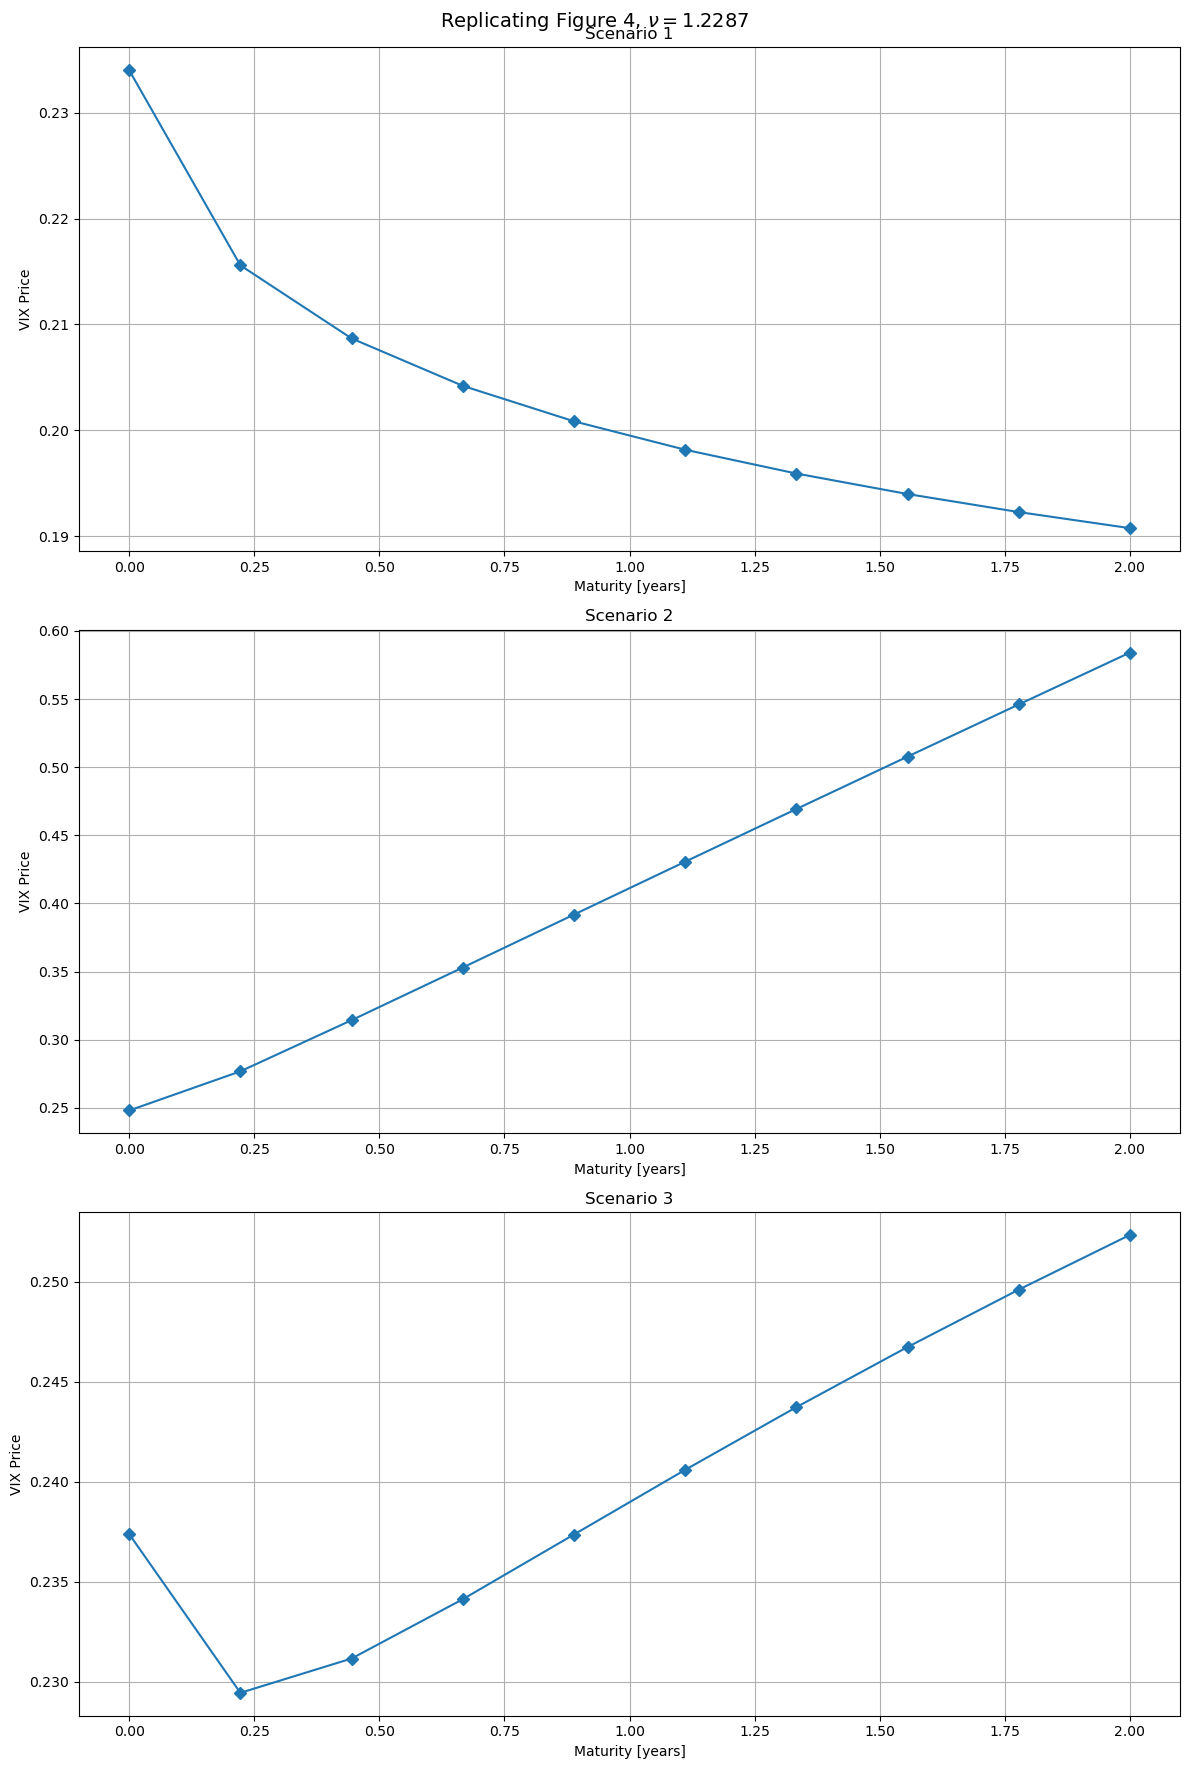

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle(r"Replicating Figure 4, $\nu = $" + f"{volvol:.4f}", fontsize=14)
maturity = np.arange(0, 2.25, 0.25)

for i, curve in enumerate((xi_1, xi_2, xi_3)):
    ax = axs[i]
    prices = []
    for tau in tqdm(maturity):
        vix = price(curve, volvol=volvol, T=tau)
        prices.append(vix)
    ax.plot(maturity, prices, marker='D')#, label=f'$\xi_{{{i+1}}}(t)$')
    ax.set_title(f"Scenario {i+1}")
    ax.set_xlabel("Maturity [years]"); ax.set_ylabel("VIX Price")
    ax.grid();  # ax.legend()

fig.tight_layout()
plt.show()

In [12]:
_wkly_mat = 5. / 252. * np.arange(1, 8)
_mthly_mat = utils.DELTA * np.arange(2, 18)
maturity = np.concatenate((_wkly_mat, _mthly_mat))

In [13]:
maturity

array([0.01984127, 0.03968254, 0.05952381, 0.07936508, 0.09920635,
       0.11904762, 0.13888889, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        , 1.08333333, 1.16666667,
       1.25      , 1.33333333, 1.41666667])

100%|█████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 841.60it/s]


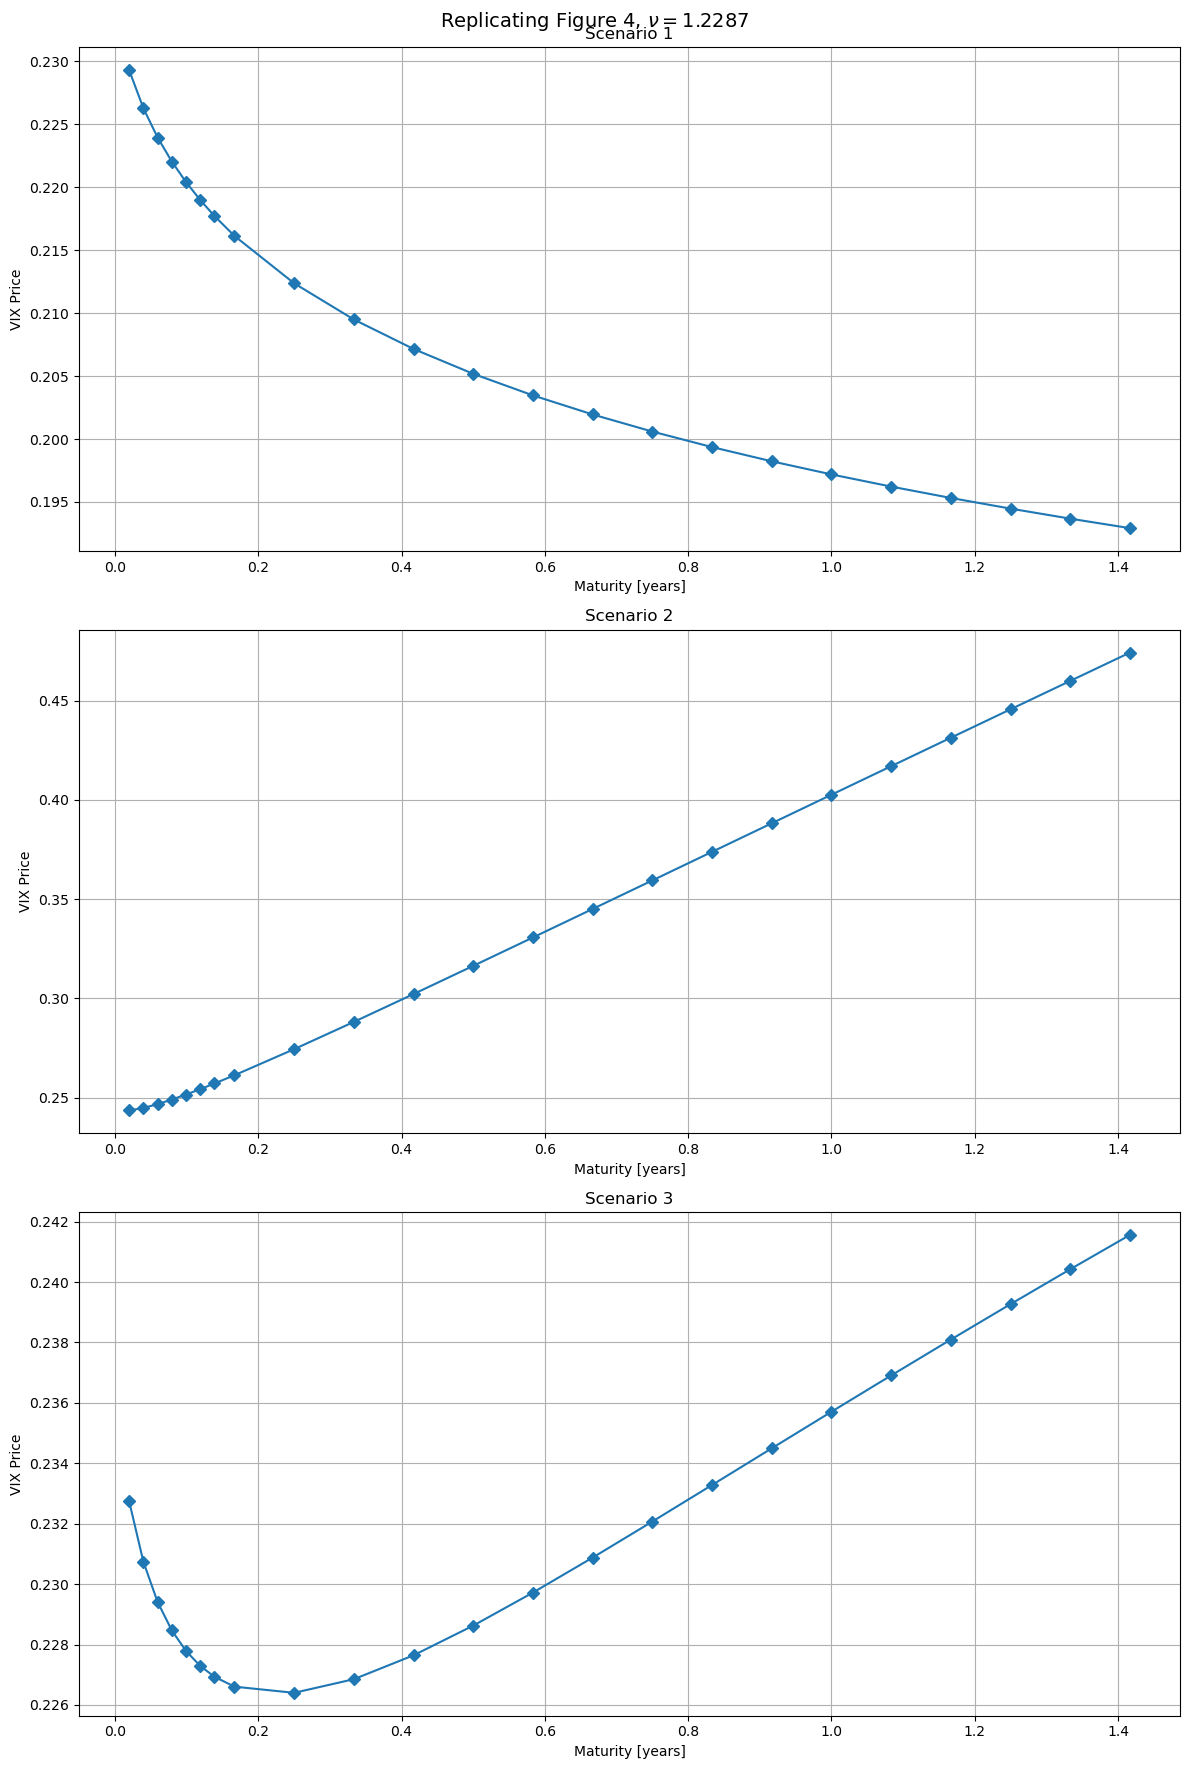

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle(r"Replicating Figure 4, $\nu = $" + f"{volvol:.4f}", fontsize=14)
# maturity = np.arange(0, 2.25, 0.25)

for i, curve in enumerate((xi_1, xi_2, xi_3)):
    ax = axs[i]
    prices = []
    for tau in tqdm(maturity):
        vix = price_jim(curve, volvol=volvol, T=tau)
        prices.append(vix)
    ax.plot(maturity, prices, marker='D')#, label=f'$\xi_{{{i+1}}}(t)$')
    ax.set_title(f"Scenario {i+1}")
    ax.set_xlabel("Maturity [years]"); ax.set_ylabel("VIX Price")
    ax.grid();  # ax.legend()

fig.tight_layout()
# plt.savefig('./Plots/vix_futures_scenarios.png')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [01:22<00:00,  3.61s/it]


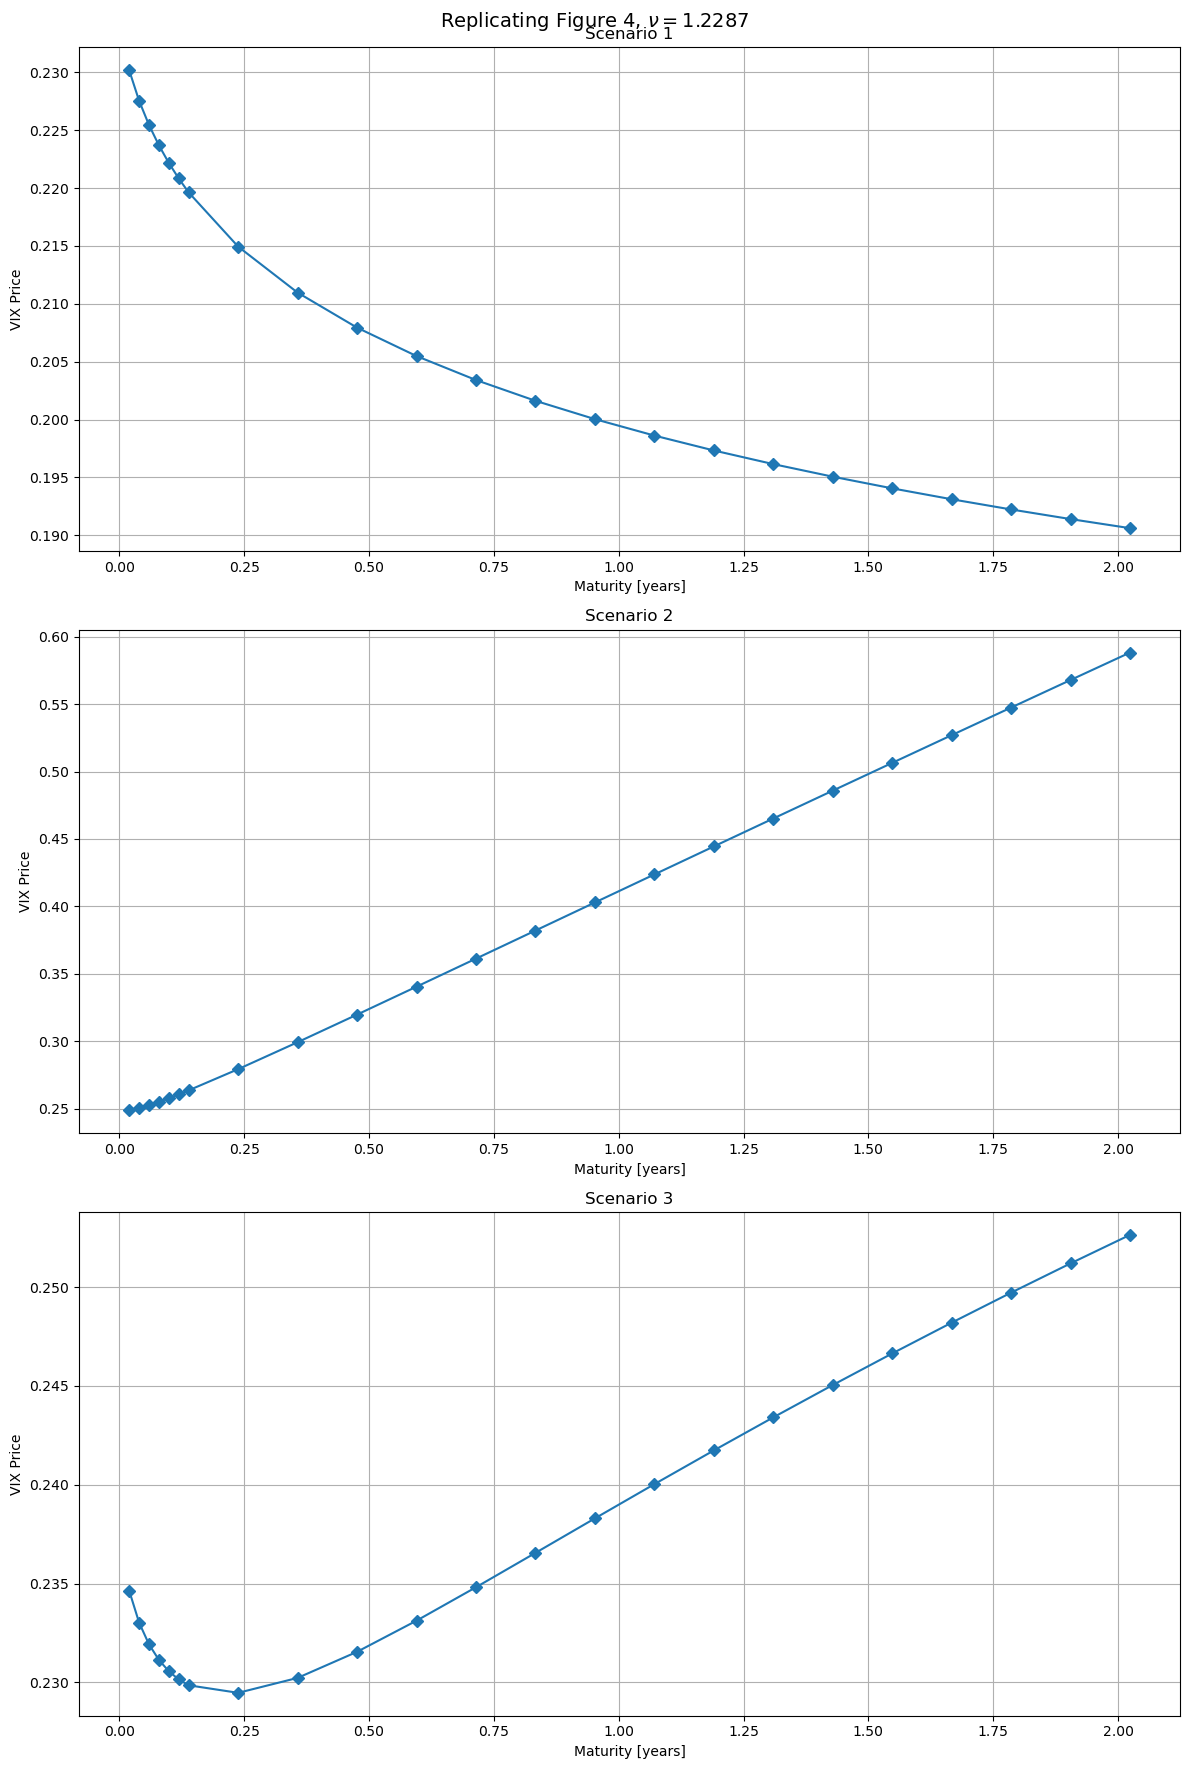

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle(r"Replicating Figure 4, $\nu = $" + f"{volvol:.4f}", fontsize=14)
# maturity = np.arange(0, 2.25, 0.25)

for i, curve in enumerate((xi_1, xi_2, xi_3)):
    ax = axs[i]
    prices = []
    for tau in tqdm(maturity):
        vix = price(curve, volvol=volvol, T=tau)
        prices.append(vix)
    ax.plot(maturity, prices, marker='D')#, label=f'$\xi_{{{i+1}}}(t)$')
    ax.set_title(f"Scenario {i+1}")
    ax.set_xlabel("Maturity [years]"); ax.set_ylabel("VIX Price")
    ax.grid();  # ax.legend()

fig.tight_layout()
# plt.savefig('./Plots/vix_futures_scenarios.png')
plt.show()

In [18]:
price(xi_1, volvol, utils.DELTA)

0.2217753543420554